In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from analyzeradprofile import *
from fitellipse import *

In [2]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/HD143006tapered.image.fits',
                          'distance':165,
                          'incl' : 15,
                          'PA' : 165,
                          'offsetx' : -3*.003,
                          'offsety' : 7*.003,
                          'size': 1.4,
                          'gamma': 1.0,
                         }
maxrad = 80
radialbins = 1+2*np.arange(maxrad/2)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "


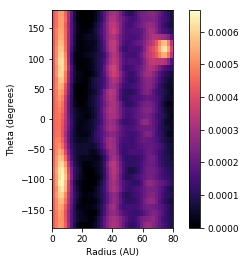

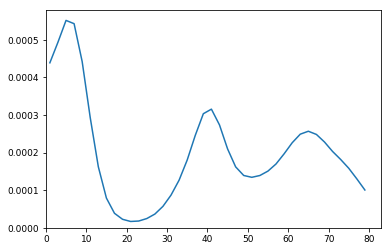

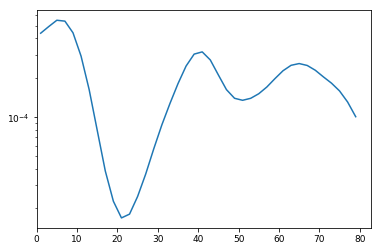

In [3]:

cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])

surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = disk['gamma']))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.show()

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -6.300e-03 arcsec, delta_y = 2.153e-02 arcsec
The MLE semi-major axis is r = 0.247 arcsec
The MLE inclination is i = 18.981 degrees
The MLE position angle is PA = 169.081 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -1.233e+01


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


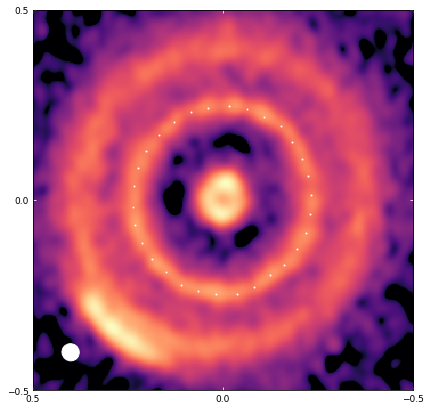

In [3]:

# Extract the ring that's at ~40 AU
xcoords1, ycoords1 = cont.extract_ring(35,45,tbins = -174+12*np.arange(30), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     45/160.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)


In [4]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and 0<cosi<1 and np.pi/2. < par < 3*np.pi/2. and -15<logvar<-5:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 30
nthreads = 8
nsteps = 20000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [5]:
np.savez("HD143006ellipsechains.npz", BR41 = sampler1.chain)

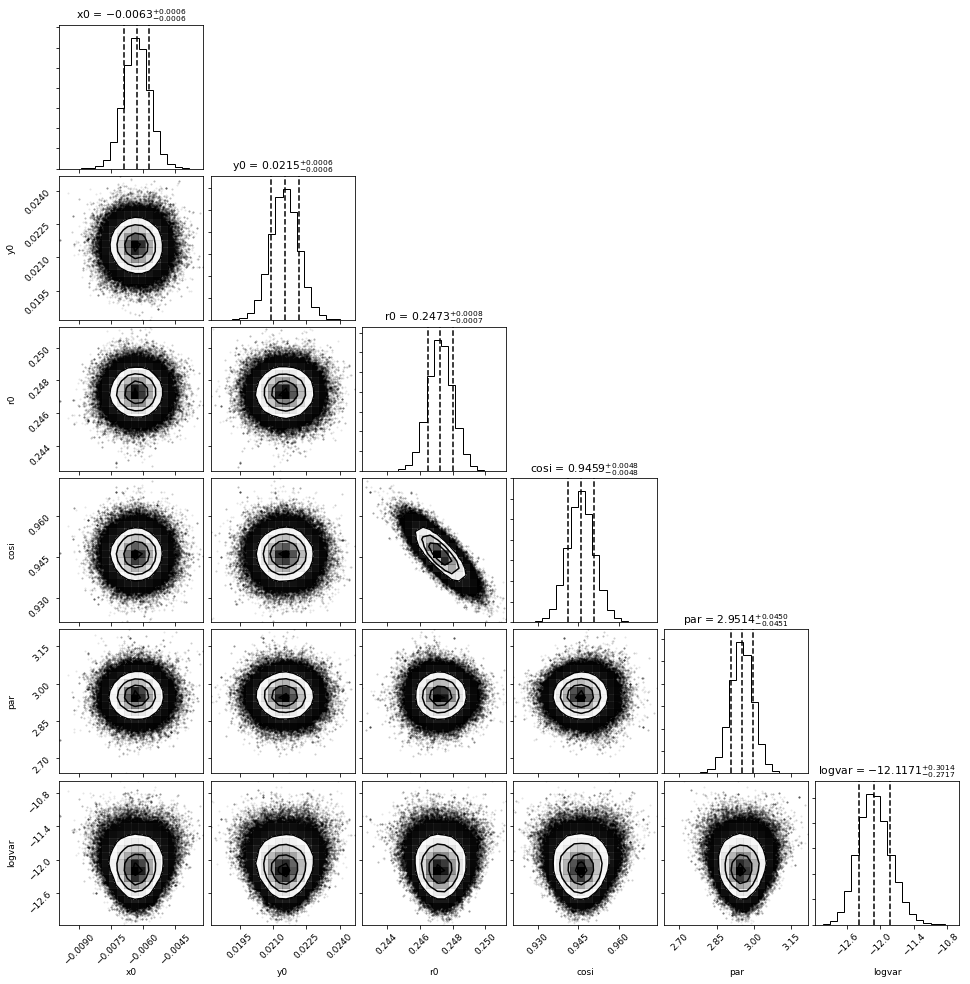

The x offset is delta_x = -6.30e-03 arcsec (+5.9e-04, -6.0e-04)
The y offset is delta_y = 2.15e-02 arcsec (+6.3e-04, -6.2e-04)
The median semi-major axis is r = 0.2473 arcsec (+0.0008, -0.0007) 
or 40.80 AU (+0.10, -0.10)
The incl is i = 18.93 deg (+0.83, -0.87)
The median position angle is PA = 169.10 deg (+2.58, -2.58)
The median log-variance in the pixel offsets from the true ellipse is -1.212e+01


In [6]:

plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1257: UserWarning: Power-law scaling on negative values is ill-defined, clamping to 0.
  warnings.warn("Power-law scaling on negative values is "
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -1.274e-03 arcsec, delta_y = 2.340e-02 arcsec
The MLE semi-major axis is r = 0.394 arcsec
The MLE inclination is i = 17.438 degrees
The MLE position angle is PA = 163.865 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -9.848e+00


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


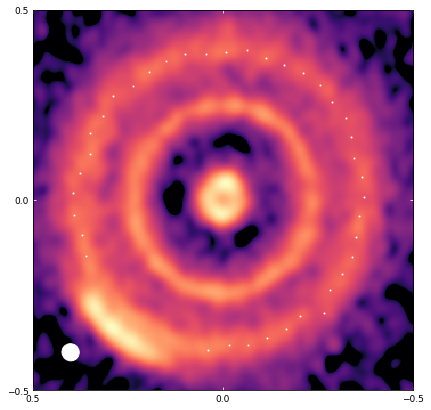

In [7]:

# Extract the ring that's at ~65 AU
xcoords2, ycoords2 = cont.extract_ring(60,70,tbins = np.concatenate((-176+8*np.arange(33),144+8*np.arange(5))), extract_type = 'max')

cont.plot_extracted_ring(cont,xcoords2, ycoords2, 0.4, 1)

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_2 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     65/160.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords2, ycoords2)


In [8]:
sampler2 = run_mcmc(nwalkers, nthreads, nsteps, mle_2, lnprob, xcoords2, ycoords2)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

In [9]:
np.savez("HD143006ellipsechains.npz", BR41 = sampler1.chain, BR65 = sampler2.chain)

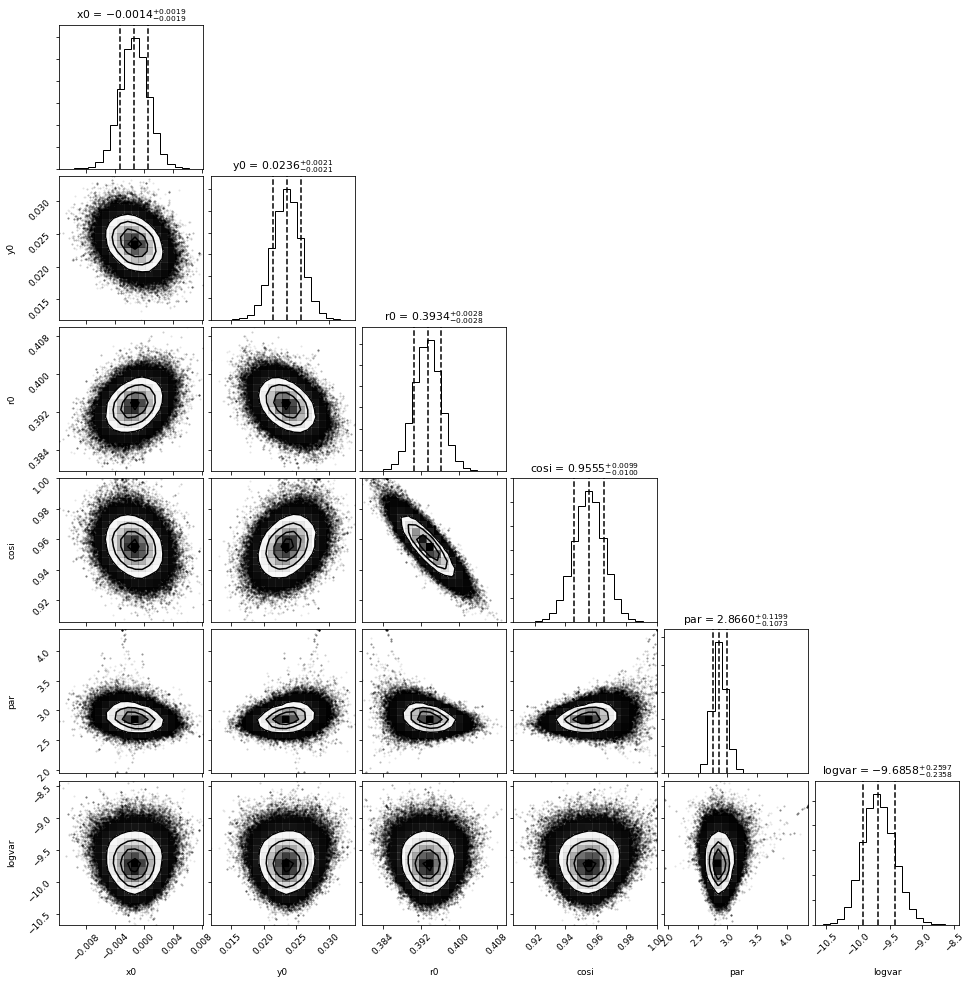

The x offset is delta_x = -1.40e-03 arcsec (+1.9e-03, -1.9e-03)
The y offset is delta_y = 2.36e-02 arcsec (+2.1e-03, -2.1e-03)
The median semi-major axis is r = 0.3934 arcsec (+0.0028, -0.0028) 
or 64.91 AU (+0.35, -0.35)
The incl is i = 17.16 deg (+1.85, -2.04)
The median position angle is PA = 164.21 deg (+6.87, -6.15)
The median log-variance in the pixel offsets from the true ellipse is -9.686e+00


In [10]:

plot_corner(sampler2, 500, 1)
sampler_results(sampler2, 500, cont.src_distance)

In [3]:

radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots
newcont = Continuum(disk['filename'], -0.0059,0.0217, 168.5, 18.6,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36),theta_exclusion = np.array([80,144]))


print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [5, 40, 64]
min [22, 51]


/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1218: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


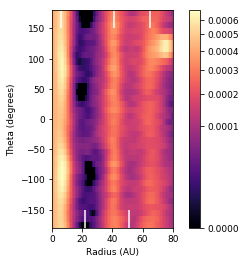

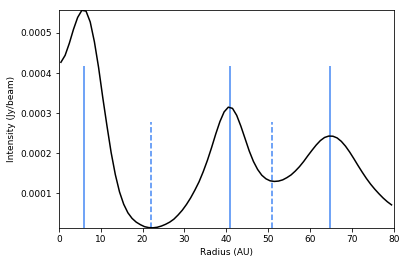

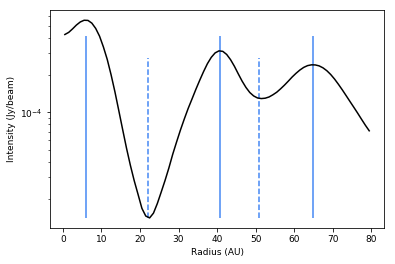

(0, 80)

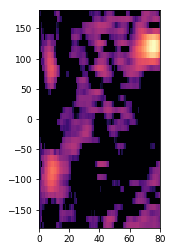

In [5]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
gaps = np.array([22,51])
rings = np.array([6, 40.8, 64.9])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.percentile(newrtmap, 50, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)


In [13]:
Imean = 0.5*(np.max(newsurfbrightness)+newsurfbrightness[0])
print(np.argmin(np.abs(Imean-newsurfbrightness[:6])))
print(np.argmin(np.abs(Imean-newsurfbrightness[6:]))+6)

3
8


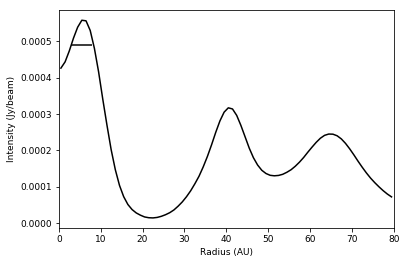

In [14]:
plt.plot(radialbins, newsurfbrightness, color = 'black')
plt.hlines(.00049, 3, 8)
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.show()

In [6]:
measure_widths(22.001,40.8, radialbins, newsurfbrightness, 0, 55)

0.000163907698964 34.9


(21.699999999999996, 12.399999999999999)

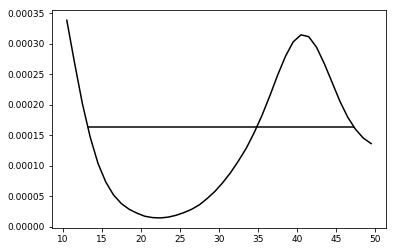

In [9]:
plt.plot(radialbins[10:50], newsurfbrightness[10:50], color = 'black')
plt.hlines(0.000163907698964, 34.9-21.7, 34.9)
plt.hlines(0.000163907698964, 34.9, 34.9+12.4)

In [4]:
calc_contrast(22.001, 40.8, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.044824328155875559, 0.018148389957462551)

In [11]:
measure_widths(51.001,64.9, radialbins, newsurfbrightness, 40, 100)

0.000186266899368 59.0


(12.799999999999997, 11.5)

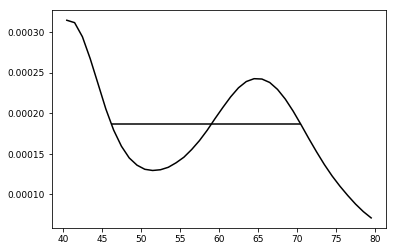

In [13]:
plt.plot(radialbins[40:80], newsurfbrightness[40:80], color = 'black')
plt.hlines(0.000186266899368, 59-12.8, 59)
plt.hlines(0.000186266899368, 59, 59+11.5)

In [5]:
calc_contrast(51.001,64.9, radialbins, newsurfbrightness, newSB_scatter, newcont)

(0.53422964319704436, 0.01844963416780921)

81.5


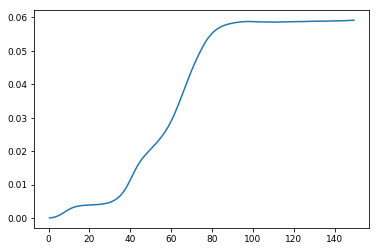

In [5]:
bins = 0.5+1*np.arange(0, 150)

cumeflux = newcont.cumefluxprofile(bins)

plt.plot(bins, cumeflux)
print(bins[np.argmin(np.abs(cumeflux-0.95*np.max(cumeflux)))])